# Análises das features semanais

Notebook gerado automaticamente para explorar os dados de `data/features/*.parquet`. As células abaixo trazem estatísticas gerais, inspeção de valores faltantes, distribuição das classes e visões temporais de colunas-chave. Ajuste ou acrescente análises conforme necessário.

In [22]:
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.style.use('ggplot')
sns.set_palette('viridis')

In [23]:
def find_project_root(marker='configs/config.yaml'):
    # Busca o diretório raiz do projeto procurando pelo arquivo marcador.
    path = Path.cwd().resolve()
    for candidate in [path, *path.parents]:
        if (candidate / marker).exists():
            return candidate
    raise FileNotFoundError(f'Não foi possível localizar {marker} em {path} ou ancestrais.')

PROJECT_ROOT = find_project_root()
DATA_DIR = PROJECT_ROOT / 'data' / 'features'
CONFIG_PATH = PROJECT_ROOT / 'configs' / 'config.yaml'

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

with open(CONFIG_PATH, 'r', encoding='utf-8') as fp:
    CFG = yaml.safe_load(fp)

print(f'Raiz do projeto: {PROJECT_ROOT}')
print('Arquivos disponíveis em DATA_DIR:')
for item in sorted(DATA_DIR.glob('*.parquet')):
    print(' -', item.name)

Raiz do projeto: D:\OneDrive\Documentos\Profissional\Pós IA IFG\Matérias\Trabalho Final Módulo 2\versaoGitHub
Arquivos disponíveis em DATA_DIR:
 - features_test_holdout.parquet
 - features_trainval.parquet
 - features_weekly.parquet


In [24]:
from src.train import rotular_semana, compute_label_thresholds


parquet_paths = {
    'trainval': DATA_DIR / 'features_trainval.parquet',
    'holdout': DATA_DIR / 'features_test_holdout.parquet',
    'weekly_full': DATA_DIR / 'features_weekly.parquet',
}

frames = {}
for name, path in parquet_paths.items():
    if path.exists():
        frames[name] = pd.read_parquet(path)
        print(f"{name}: {frames[name].shape[0]:,} linhas x {frames[name].shape[1]:,} colunas")
    else:
        print(f"[aviso] Arquivo não encontrado: {path}")

for df in frames.values():
    if isinstance(df.index, pd.DatetimeIndex):
        df.sort_index(inplace=True)

frames

trainval: 359 linhas x 896 colunas
holdout: 81 linhas x 896 colunas
weekly_full: 403 linhas x 896 colunas


{'trainval':                            carga_mwh_mean_w  carga_mwh_sum_w  carga_mwh_max_w  \
 2018-01-07 00:00:00+00:00               NaN              NaN              NaN   
 2018-01-14 00:00:00+00:00               NaN              NaN              NaN   
 2018-01-21 00:00:00+00:00               NaN              NaN              NaN   
 2018-01-28 00:00:00+00:00               NaN              NaN              NaN   
 2018-02-04 00:00:00+00:00               NaN              NaN              NaN   
 ...                                     ...              ...              ...   
 2024-02-11 00:00:00+00:00      2.266650e+06     1.586655e+07      2381313.771   
 2024-02-18 00:00:00+00:00      2.202484e+06     1.541739e+07      2363546.376   
 2024-02-18 00:00:01+00:00      2.202484e+06     1.541739e+07      2363546.376   
 2024-02-25 00:00:00+00:00      2.227188e+06     1.559032e+07      2338724.903   
 2024-03-03 00:00:00+00:00      2.381197e+06     1.666838e+07      2540284.010   
 
  

## Panorama geral

In [26]:
!pip install jinja2
overview_rows = []
for name, df in frames.items():
    overview_rows.append({
        'dataset': name,
        'linhas': len(df),
        'colunas': df.shape[1],
        'inicio': df.index.min(),
        'fim': df.index.max(),
        'tipo_index': type(df.index).__name__,
    })

overview = pd.DataFrame(overview_rows)
display(overview)

for name, df in frames.items():
    numeric_stats = df.select_dtypes(include=[np.number]).describe().loc[['mean', 'std', 'min', 'max']]
    display(numeric_stats.T.head(10).style.format(precision=2).set_caption(f'Estatísticas numéricas (top 10 colunas) - {name}'))

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-win_amd64.whl.metadata (4.1 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached MarkupSafe-3.0.2-cp313-cp313-win_amd64.whl (15 kB)

   -------------------- ------------------- 1/2 [jinja2]
   -------------------- ------------------- 1/2 [jinja2]
   -------------------- ------------------- 1/2 [jinja2]
   -------------------- ------------------- 1/2 [jinja2]
   -------------------- ------------------- 1/2 [jinja2]
   ---------------------------------------- 2/2 [jinja2]



,dataset,linhas,colunas,inicio,fim,tipo_index
0,trainval,359,896,2018-01-07 00:00:00+00:00,2024-03-03 00:00:00+00:00,DatetimeIndex
1,holdout,81,896,2024-03-10 00:00:00+00:00,2025-09-21 00:00:00+00:00,DatetimeIndex
2,weekly_full,403,896,2018-01-07 00:00:00+00:00,2025-09-21 00:00:00+00:00,DatetimeIndex


,mean,std,min,max
carga_mwh_mean_w,1973039.45,152828.97,1625354.99,2429133.44
carga_mwh_sum_w,13798707.40,1100961.80,9269470.89,17003934.06
carga_mwh_max_w,2093919.98,172183.40,1687592.30,2572253.48
carga_mwh_min_w,1744100.24,142340.28,1449363.50,2135613.80
carga_mwh_std_w,125984.05,33591.42,55331.44,245284.35
carga_mwh__p95_w,2086913.84,170362.69,1685809.65,2571449.81
carga_mwh__p05_w,1787590.52,141914.44,1499655.94,2198099.05
ger_hidreletrica_mwh_mean_w,689666.71,98332.16,417890.27,902638.13
ger_hidreletrica_mwh_sum_w,4827666.94,688325.14,2925231.87,6318466.88
ger_hidreletrica_mwh_max_w,743038.27,106297.04,463013.99,973053.73


,mean,std,min,max
carga_mwh_mean_w,2133554.26,164333.32,1643418.69,2556205.04
carga_mwh_sum_w,14894301.60,1318546.53,8217093.43,17893435.26
carga_mwh_max_w,2267003.92,170243.75,2033038.04,2684865.49
carga_mwh_min_w,1862347.84,254943.61,0.00,2246047.58
carga_mwh_std_w,146618.44,96774.79,80037.15,950028.14
carga_mwh__p95_w,2259883.17,168661.36,2025284.95,2674867.14
carga_mwh__p05_w,1915569.27,228771.32,328519.57,2310955.35
ger_hidreletrica_mwh_mean_w,647379.27,117241.81,480666.57,902834.19
ger_hidreletrica_mwh_sum_w,4496374.84,901268.10,1143072.64,6319839.35
ger_hidreletrica_mwh_max_w,700198.18,128313.97,516288.70,999926.35


,mean,std,min,max
carga_mwh_mean_w,1991946.24,169270.67,1625354.99,2556205.04
carga_mwh_sum_w,13922990.58,1242913.96,8217093.43,17893435.26
carga_mwh_max_w,2114034.45,185599.42,1687592.30,2684865.49
carga_mwh_min_w,1753349.16,179482.22,0.00,2246047.58
carga_mwh_std_w,130034.25,56219.87,55331.44,950028.14
carga_mwh__p95_w,2107042.34,183994.62,1685809.65,2674867.14
carga_mwh__p05_w,1799446.14,172845.80,328519.57,2310955.35
ger_hidreletrica_mwh_mean_w,676487.03,105880.94,417890.27,902834.19
ger_hidreletrica_mwh_sum_w,4728318.21,761601.37,1143072.64,6319839.35
ger_hidreletrica_mwh_max_w,728966.72,114130.60,463013.99,999926.35


## Valores faltantes

In [27]:
def top_missing(df, top=15):
    miss = df.isna().mean().mul(100).sort_values(ascending=False).head(top)
    return miss.rename('percentual_na')

missing_tables = {}
for name, df in frames.items():
    miss = top_missing(df)
    missing_tables[name] = miss
    print(f"\n{name} - top {len(miss)} colunas com mais NA (%):")
    display(miss.to_frame())

missing_tables


trainval - top 15 colunas com mais NA (%):


,percentual_na
reserve_margin_ratio_w_lag4w,18.941504
margem_vs_carga_w_lag4w,18.941504
ens_week_ratio_lag4w,18.941504
ens_week_mwh_lag4w,18.941504
carga_mwh_max_w_lag4w,18.941504
carga_mwh__p95_w_lag4w,18.941504
carga_mwh__p05_w_lag4w,18.941504
carga_mwh_sum_w_lag4w,18.941504
carga_mwh_std_w_lag4w,18.941504
carga_mwh_mean_w_lag4w,18.941504



holdout - top 15 colunas com mais NA (%):


,percentual_na
carga_mwh_mean_w,0.0
carga_mwh_sum_w,0.0
carga_mwh_max_w,0.0
carga_mwh_min_w,0.0
carga_mwh_std_w,0.0
carga_mwh__p95_w,0.0
carga_mwh__p05_w,0.0
ger_hidreletrica_mwh_mean_w,0.0
ger_hidreletrica_mwh_sum_w,0.0
ger_hidreletrica_mwh_max_w,0.0



weekly_full - top 15 colunas com mais NA (%):


,percentual_na
reserve_margin_ratio_w_lag4w,16.873449
margem_vs_carga_w_lag4w,16.873449
ens_week_ratio_lag4w,16.873449
ens_week_mwh_lag4w,16.873449
carga_mwh_max_w_lag4w,16.873449
carga_mwh__p95_w_lag4w,16.873449
carga_mwh__p05_w_lag4w,16.873449
carga_mwh_sum_w_lag4w,16.873449
carga_mwh_std_w_lag4w,16.873449
carga_mwh_mean_w_lag4w,16.873449


{'trainval': reserve_margin_ratio_w_lag4w    18.941504
 margem_vs_carga_w_lag4w         18.941504
 ens_week_ratio_lag4w            18.941504
 ens_week_mwh_lag4w              18.941504
 carga_mwh_max_w_lag4w           18.941504
 carga_mwh__p95_w_lag4w          18.941504
 carga_mwh__p05_w_lag4w          18.941504
 carga_mwh_sum_w_lag4w           18.941504
 carga_mwh_std_w_lag4w           18.941504
 carga_mwh_mean_w_lag4w          18.941504
 carga_mwh_min_w_lag4w           18.941504
 ens_week_mwh_lag2w              18.384401
 carga_mwh_max_w_lag2w           18.384401
 reserve_margin_ratio_w_lag2w    18.384401
 ens_week_ratio_lag2w            18.384401
 Name: percentual_na, dtype: float64,
 'holdout': carga_mwh_mean_w               0.0
 carga_mwh_sum_w                0.0
 carga_mwh_max_w                0.0
 carga_mwh_min_w                0.0
 carga_mwh_std_w                0.0
 carga_mwh__p95_w               0.0
 carga_mwh__p05_w               0.0
 ger_hidreletrica_mwh_mean_w    0.0
 ger_h

## Distribuição das classes (rotular_semana)

In [34]:
thresholds = compute_label_thresholds(CFG, frames['trainval'])

label_results = {}
for name, df in frames.items():
    ref_df = frames['trainval']
    labels = rotular_semana(df, CFG, ref_df=ref_df)
    labels = labels.dropna()
    label_results[name] = labels

    count = labels.value_counts().rename('contagem')
    frac = (count / count.sum()).rename('percentual')
    dist = pd.concat([count, frac.mul(100)], axis=1)
    display(dist.style.format({'percentual': '{:.2f}%'}).set_caption(f'Distribuição de classes - {name}'))

,contagem,percentual
alto,149,45.43%
baixo,140,42.68%
medio,39,11.89%


,contagem,percentual
alto,39,48.15%
baixo,34,41.98%
medio,8,9.88%


,contagem,percentual
alto,185,49.73%
baixo,162,43.55%
medio,25,6.72%


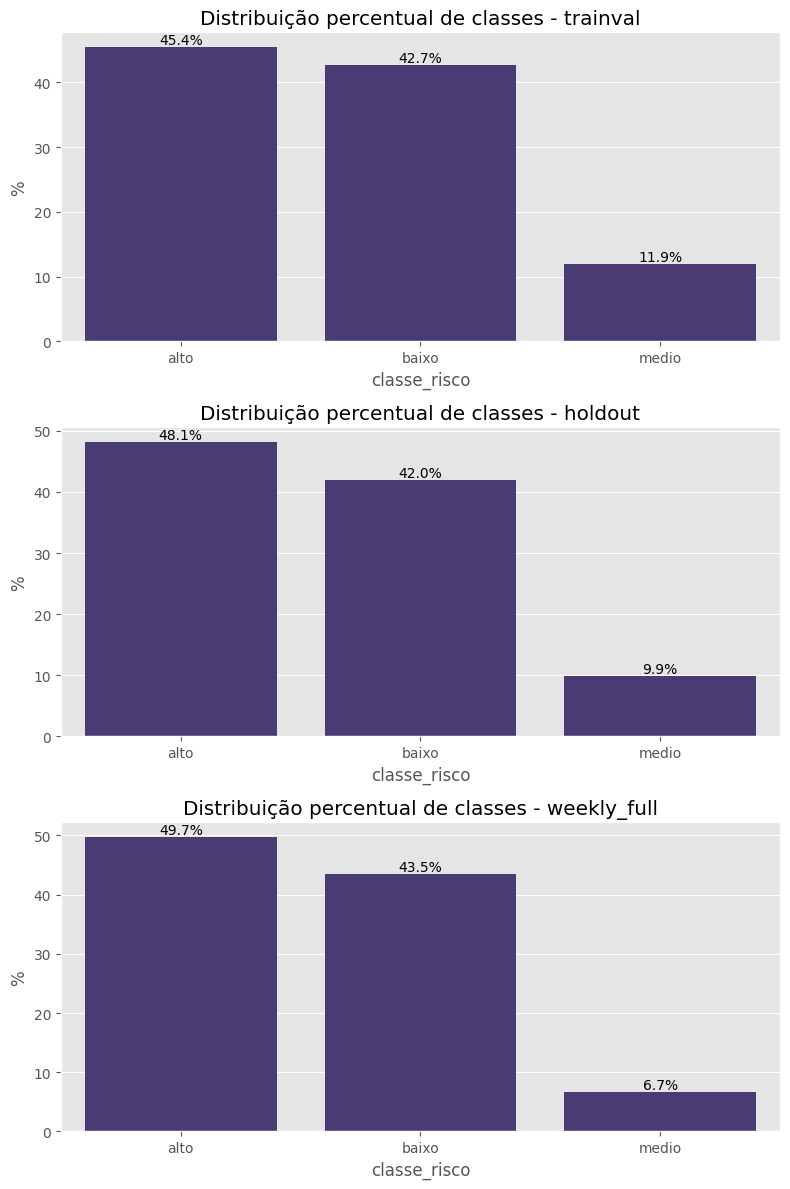

In [29]:
fig, axes = plt.subplots(len(label_results), 1, figsize=(8, 4 * len(label_results)))
if len(label_results) == 1:
    axes = [axes]

for ax, (name, labels) in zip(axes, label_results.items()):
    share = labels.value_counts(normalize=True).sort_index()
    sns.barplot(x=share.index, y=share.values * 100, ax=ax)
    ax.set_title(f'Distribuição percentual de classes - {name}')
    ax.set_ylabel('%')
    ax.set_xlabel('classe_risco')
    for x, val in enumerate(share.values * 100):
        ax.text(x, val + 0.5, f'{val:.1f}%', ha='center')
plt.tight_layout()

## Checagem de duplicatas no conjunto de treino

In [30]:
train_index = frames['trainval'].index
n_dup = train_index.duplicated().sum()
print(f'Total de índices duplicados em trainval: {n_dup}')
if n_dup:
    dup_counts = train_index[train_index.duplicated()].value_counts()
    display(dup_counts.head(10).to_frame('ocorrencias'))

Total de índices duplicados em trainval: 0


## Sinais principais ao longo do tempo

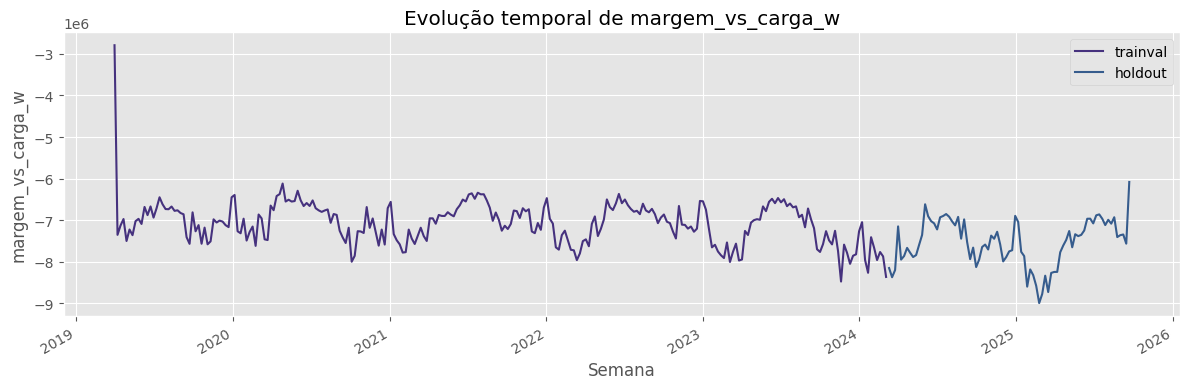

In [31]:
margem_col = CFG['problem']['label_rules'].get('coluna_margem', 'margem_vs_carga_w')

fig, ax = plt.subplots(figsize=(12, 4))
frames['trainval'][margem_col].plot(ax=ax, label='trainval')
if 'holdout' in frames:
    frames['holdout'][margem_col].plot(ax=ax, label='holdout')
ax.set_title(f'Evolução temporal de {margem_col}')
ax.set_xlabel('Semana')
ax.set_ylabel(margem_col)
ax.legend()
plt.tight_layout()

## Correlação entre variáveis numéricas (treino)

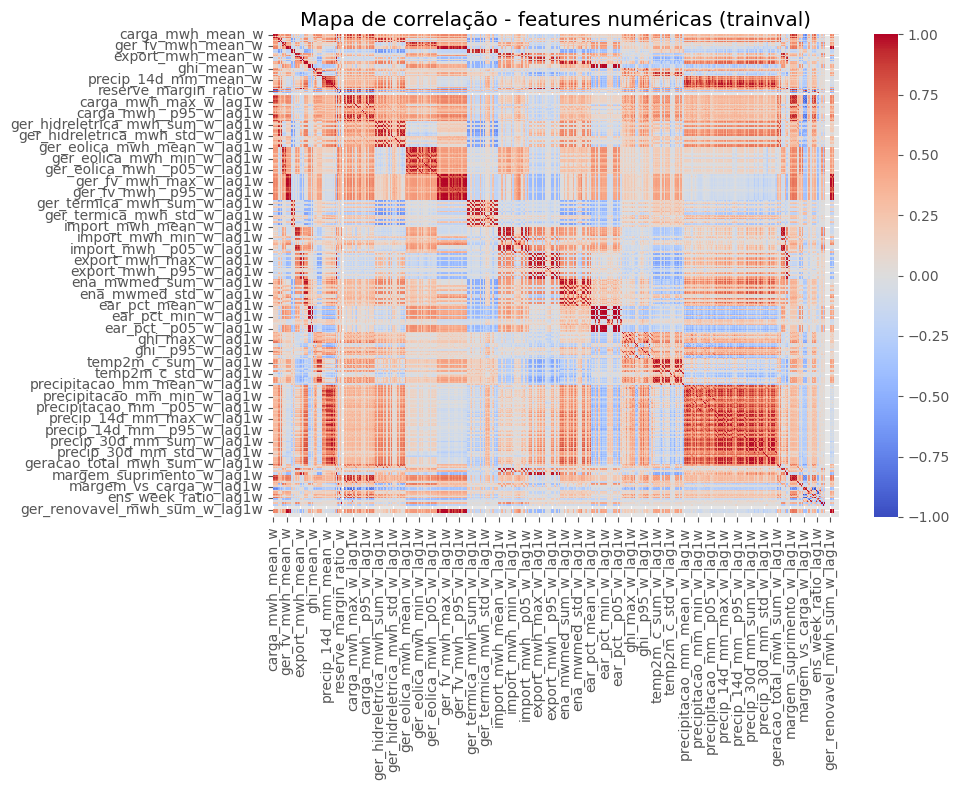

In [32]:
corr = frames['trainval'].select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Mapa de correlação - features numéricas (trainval)')
plt.tight_layout()